tgb - 4/22/2019  
- Figures from notebook 010
- We will train unconstrained (U), loss-constrained (L) and architecture-constrained (A) neural networks trained on the 8-column +0K experiment and validated on the same experiment. The loss-constrained networks will have varying architectures to see how MSE and energy conservation performances vary with the importance given to each in the loss function.  
  
Notebook 009 follows the notebook 005 that predicts:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 

# 1) Load modules and create training/validation data generators

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


## 2) Load model and statistics

tgb - 5/20/2019 - Loading a model using json

In [2]:
#NN = load_model(TRAINDIR+'HDF5_DATA/'+'Jordan02_json.h5')
# import json
# dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
# NN = model_from_json(open(TRAINDIR+'HDF5_DATA/'+'Jordan02_json.h5','r').read(),custom_objects=dict_lay)
# NN.load_weights(TRAINDIR+'HDF5_DATA/'+'Jordan02.h5')

In [6]:
sst = 0; # Simulation +sst * K
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints

MSEa = {}; PENa = {}; MSESTDa = {}; PENSTDa = {};
#MASa = {}; ENTa = {}; SWa = {}; LWa = {}; 
for alpha in alpha_array:
    NN = {}; md = {};
    print('alpha = ',str(alpha))
    # 0) Define model/statistics to load
    config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
    dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
    # Path of model/statistics
    path_model = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'.h5'
    if sst==0:
        data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
        path_md = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md.pkl'
        path_res = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res.pkl'
    else:
        data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_1'+str(sst)+'_valid.nc'
        path_md = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md'+str(sst)+'K.pkl'
        path_res = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res'+str(sst)+'K.pkl'

    # 1) Load model
    NN = load_model(path_model,custom_objects=dict_lay)

    # 2) Define and load md
    md = ModelDiagnostics(NN,config_fn,data_fn)
    md.stats = pickle.load(open(path_md,'rb'))

    # 3) Load res
    md.res = pickle.load(open(path_res,'rb'))

    # 4) Fill the MSE and energy/enthalpy arrays as function of alpha
    MSEa[str(alpha)] = md.mse_W2m4().mean((0,1,2))
    PENa[str(alpha)] = 0.25*(md.res['mass']+md.res['ent']+\
                             md.res['sw']+md.res['lw']).mean((0,1,2))
    MSESTDa[str(alpha)] = md.mse_W2m4().std((0,1,2))
    PENSTDa[str(alpha)] = 0.25*(md.res['mass']+md.res['ent']+\
                             md.res['sw']+md.res['lw']).std((0,1,2))
        

print('NNA network')
# Repeat for architecture-constrained network
# Path of model/statistics
path_model = TRAINDIR+'HDF5_DATA/NNA.h5'
if sst==0:
    path_md = TRAINDIR+'HDF5_DATA/NNAmd.pkl'
    path_res = TRAINDIR+'HDF5_DATA/NNAres.pkl'
else:
    path_md = TRAINDIR+'HDF5_DATA/NNAmd'+str(sst)+'K.pkl'
    path_res = TRAINDIR+'HDF5_DATA/NNAres'+str(sst)+'K.pkl'
# 1) Load model
NN = load_model(path_model,custom_objects=dict_lay)
# 2) Define and load md
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(path_md,'rb'))
# 3) Load res
md.res = pickle.load(open(path_res,'rb'))
# 4) Fill the MSE and energy/enthalpy arrays
MSEa['NNA'] = md.mse_W2m4().mean((0,1,2))
PENa['NNA'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).mean((0,1,2))
MSESTDa['NNA'] = md.mse_W2m4().std((0,1,2))
PENSTDa['NNA'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).std((0,1,2))

print('MLR0 network')
# Repeat for architecture-constrained network
# Path of model/statistics
path_model = TRAINDIR+'HDF5_DATA/MLRL0.h5'
if sst==0:
    path_md = TRAINDIR+'HDF5_DATA/MLRL0md.pkl'
    path_res = TRAINDIR+'HDF5_DATA/MLRL0res.pkl'
else:
    path_md = TRAINDIR+'HDF5_DATA/MLRL0md'+str(sst)+'K.pkl'
    path_res = TRAINDIR+'HDF5_DATA/MLRL0res'+str(sst)+'K.pkl'
# 1) Load model
NN = load_model(path_model,custom_objects=dict_lay)
# 2) Define and load md
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(path_md,'rb'))
# 3) Load res
md.res = pickle.load(open(path_res,'rb'))
# 4) Fill the MSE and energy/enthalpy arrays
MSEa['MLRL0'] = md.mse_W2m4().mean((0,1,2))
PENa['MLRL0'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).mean((0,1,2))
MSESTDa['MLRL0'] = md.mse_W2m4().std((0,1,2))
PENSTDa['MLRL0'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).std((0,1,2))

print('NNAU network')
# Repeat for architecture-constrained network
# Path of model/statistics
path_model = TRAINDIR+'HDF5_DATA/NNA0.01.h5'
if sst==0:
    path_md = TRAINDIR+'HDF5_DATA/NNA0.01md.pkl'
    path_res = TRAINDIR+'HDF5_DATA/NNA0.01res.pkl'
else:
    path_md = TRAINDIR+'HDF5_DATA/NNA0.01md'+str(sst)+'K.pkl'
    path_res = TRAINDIR+'HDF5_DATA/NNA0.01res'+str(sst)+'K.pkl'
# 1) Load model
NN = load_model(path_model,custom_objects=dict_lay)
# 2) Define and load md
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(path_md,'rb'))
# 3) Load res
md.res = pickle.load(open(path_res,'rb'))
# 4) Fill the MSE and energy/enthalpy arrays
MSEa['NNA0.01'] = md.mse_W2m4().mean((0,1,2))
PENa['NNA0.01'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).mean((0,1,2))
MSESTDa['NNA0.01'] = md.mse_W2m4().std((0,1,2))
PENSTDa['NNA0.01'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).std((0,1,2))

NNarray = ['J01_NNU','J01_NNA','J01_NNL','J01_NNLA']
for i in range(len(NNarray)):
    NN = {}
    print('i=',i)
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)    
    md = {}
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+
                               'md'+'.pkl','rb'))
    # 4) Fill the MSE array
    MSEa[NNarray[i]] = md.mse_W2m4().mean((0,1,2))
    MSESTDa[NNarray[i]] = md.mse_W2m4().std((0,1,2))

# print('MLRA network')
# # Repeat for architecture-constrained network
# # Path of model/statistics
# path_model = TRAINDIR+'HDF5_DATA/MLRA.h5'
# if sst==0:
#     path_md = TRAINDIR+'HDF5_DATA/MLRAmd.pkl'
#     path_res = TRAINDIR+'HDF5_DATA/MLRAres.pkl'
# else:
#     path_md = TRAINDIR+'HDF5_DATA/MLRAmd'+str(sst)+'K.pkl'
#     path_res = TRAINDIR+'HDF5_DATA/MLRAres'+str(sst)+'K.pkl'
# # 1) Load model
# NN = load_model(path_model,custom_objects=dict_lay)
# # 2) Define and load md
# md = ModelDiagnostics(NN,config_fn,data_fn)
# md.stats = pickle.load(open(path_md,'rb'))
# # 3) Load res
# md.res = pickle.load(open(path_res,'rb'))
# # 4) Fill the MSE and energy/enthalpy arrays
# MSEa['MLRA'] = md.mse_W2m4().mean((0,1,2))
# PENa['MLRA'] = 0.25*(md.res['mass']+md.res['ent']+\
#                     md.res['sw']+md.res['lw']).mean((0,1,2))
# MSESTDa['MLRA'] = md.mse_W2m4().std((0,1,2))
# PENSTDa['MLRA'] = 0.25*(md.res['mass']+md.res['ent']+\
#                     md.res['sw']+md.res['lw']).std((0,1,2))

alpha =  0
alpha =  0.01
alpha =  0.25
alpha =  0.5
alpha =  0.75
alpha =  0.99
alpha =  1
NNA network
MLR0 network
NNAU network
i= 0
Loading model
Loading statistics


NameError: name 'data_fn_array' is not defined

In [9]:
NNarray = ['J01_NNU','J01_NNA','J01_NNL','J01_NNLA']
for i in range(len(NNarray)):
    NN = {}
    print('i=',i)
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)    
    md = {}
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+
                               'md'+'.pkl','rb'))
    # 4) Fill the MSE array
    MSEa[NNarray[i]] = md.mse_W2m4().mean((0,1,2))
    MSESTDa[NNarray[i]] = md.mse_W2m4().std((0,1,2))

i= 0
Loading model
Loading statistics
i= 1
Loading model
Loading statistics
i= 2
Loading model
Loading statistics
i= 3
Loading model
Loading statistics


In [10]:
MSEa

{'0': 154.18735999979424,
 '0.01': 151.63750878806195,
 '0.25': 163.8660779267188,
 '0.5': 177.20805425056002,
 '0.75': 212.16629553845567,
 '0.99': 388.51354581649787,
 '1': 2125.4165518263144,
 'NNA': 168.94318558526123,
 'MLRL0': 295.27497987468007,
 'NNA0.01': 161.8958649712603,
 'J01_NNU': 181.5904078597563,
 'J01_NNA': 184.1659055532139,
 'J01_NNL': 254.90655693510985,
 'J01_NNLA': 192.48733926176757}

In [5]:
NN = {}; md = {};
sst = 0; # Simulation +sst * K
alpha_array = [0,0.01]

for alpha in alpha_array:
    print('alpha = ',str(alpha))
    # 0) Define model/statistics to load
    config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
    dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
    # Path of model/statistics
    path_model = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'.h5'
    if sst==0:
        data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
        path_md = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md.pkl'
        path_res = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res.pkl'
    elif sst==10:
        data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_train.nc'
        path_md = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md.pkl'
        path_res = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res.pkl'
    else:
        data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_1'+str(sst)+'_valid.nc'
        path_md = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md'+str(sst)+'K.pkl'
        path_res = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res'+str(sst)+'K.pkl'

    # 1) Load model
    NN = load_model(path_model,custom_objects=dict_lay)

    # 2) Define and load md
    md = ModelDiagnostics(NN,config_fn,data_fn)
    md.compute_stats(niter=100)
    print(md.mse_W2m4().mean((0,1,2)))
    
    pickle.dump(md.stats,open(path_md,'wb'))
    print('Stats are saved in ',path)

alpha =  0


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:143: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:149: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


154.18735999979424
Stats are saved in  <module 'posixpath' from '/home/t/Tom.Beucler/miniconda3/lib/python3.6/posixpath.py'>
alpha =  0.01


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:143: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:149: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


151.63750878806195
Stats are saved in  <module 'posixpath' from '/home/t/Tom.Beucler/miniconda3/lib/python3.6/posixpath.py'>


In [8]:
md.mse_W2m4().std((0,1,2))

1694.8853116219402

In [78]:
# tgb - 4/22/2019 - Brewer color palettes from Github colorbrewer-python-master
Set1 = {
    3: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)'],
    4: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)'],
    5: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)'],
    6: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)'],
    7: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)'],
    8: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)'],
    9: ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)', 'rgb(153,153,153)']
}
Set2 = {
    3: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)'],
    4: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)'],
    5: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)'],
    6: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)', 'rgb(255,217,47)'],
    7: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)', 'rgb(255,217,47)', 'rgb(229,196,148)'],
    8: ['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)', 'rgb(255,217,47)', 'rgb(229,196,148)', 'rgb(179,179,179)']
}
Set3 = {
    3: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)'],
    4: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)'],
    5: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)'],
    6: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)'],
    7: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)'],
    8: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)'],
    9: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)'],
    10: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)'],
    11: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)', 'rgb(204,235,197)'],
    12: ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)', 'rgb(204,235,197)', 'rgb(255,237,111)']
}
print(Set1[9])

['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)', 'rgb(152,78,163)', 'rgb(255,127,0)', 'rgb(255,255,51)', 'rgb(166,86,40)', 'rgb(247,129,191)', 'rgb(153,153,153)']


In [94]:
eval(cmap[1][3:])
MSEa['NNA']

168.94318558526123

# 3) Figures  
## 3.1) Figure 3: Performances of convective parametrization  
### 3.1.1) Figure 3a: MSE,Penalty distribution as function of alpha for all networks

In [22]:
MSEa

{'0': 632.5298116419908,
 '0.01': 471.33877682044374,
 '0.25': 486.65525043447695,
 '0.5': 496.06610084086583,
 '0.75': 756.2056973200778,
 '0.99': 630.6448455202151,
 '1': 2449.237489014796,
 'NNA': 566.9766187723122,
 'MLRL0': 746.8456938873453}

In [23]:
MSESTDa

{'0': 7091.9880866289295,
 '0.01': 4917.028206566371,
 '0.25': 9013.030346877673,
 '0.5': 7648.271813086906,
 '0.75': 13637.565725599794,
 '0.99': 3544.9528074005025,
 '1': 27751.247550932698,
 'NNA': 8479.061908780006,
 'MLRL0': 12865.917965227658}

NameError: name 'MSEa' is not defined

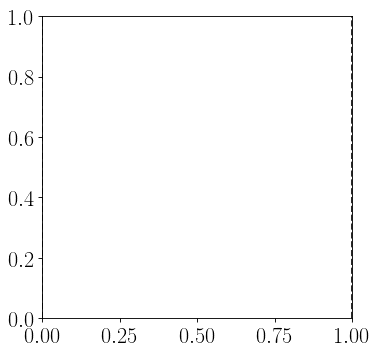

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as imag

fz = 20
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.15 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

MSEs = {}; PENs = {};

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')

plt.axvline(x=0,color='k',linestyle='--',zorder=0)
plt.axvline(x=1,color='k',linestyle='--',zorder=0)

plt.axhline(y=np.log10(MSEa['MLRL0']/SN**2),c='k',linestyle='--',zorder=1)
#plt.axhline(y=np.log10(MSEa['MLRA']/SN**2),c='b',linestyle='--',zorder=1)

for alpha in alpha_array:
    print('alpha = ',str(alpha))
    MSEs[str(alpha)] = plt.scatter(alpha,np.log10(MSEa[str(alpha)]/SN**2),c='k',s=siz)
    PENs[str(alpha)] = plt.scatter(alpha,np.log10(PENa[str(alpha)]/SN**2),c='b',s=siz)
    
MSEs['NNA'] = plt.scatter(XNNA,np.log10(MSEa['NNA']/SN**2),c='k',s=siz)
PENs['NNA'] = plt.scatter(XNNA,YMIN+0.1,c='b',s=3*siz,marker="$\downarrow$")
MSEt = plt.text(XNNA-XTEXT,np.log10(MSEa['NNA']/SN**2)-YTEXT,s='$\mathrm{NNA}$',color='k')
PENt = plt.text(XNNA-XTEXT,YMIN+0.1+YTEXT/2,s='$\mathrm{NNA}$',color='b')
    
plt.xlim((-0.05,1.3))
plt.ylim((YMIN,2.5))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\log_{10}\ \mathrm{Loss}$')
plt.legend((MSEs['0'],PENs['0']),\
           ('MSE','$\cal{P}$'))
# plt.legend((MSEs['0'],PENs['0'],MSEs['NNA'],PENs['NNA']),\
#            ('MSE','$\cal{P}$','MSE NNA','$\cal{P}\ \mathrm{NNA}$'))

### 3.1.2) Figure 3b: R2 profiles as a function of z

Loading model
Loading statistics
Loading model
Loading statistics


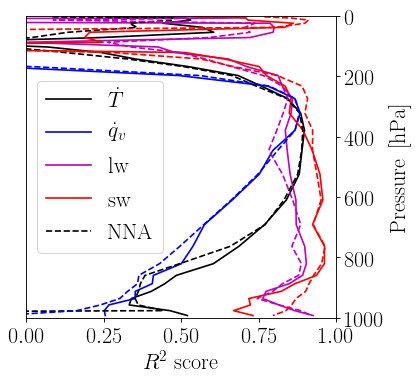

In [17]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

vec = [3,0,4,5]
COLOR = ['k','b','m','r']
LABEL = ['$\dot{T}$','$\dot{q}_{v}$','$\mathrm{lw}$','$\mathrm{sw}$','$\mathrm{NNA}$','','','','','','','']
LIN = ['-','--',':']
LINE = {}
NNarray = ['NNL0','NNA']

plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')

for j in range(len(NNarray)):
    # Load statistics
    md = {}; NN = {};
    # Load statistics
    md = {}; NN = {};
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[j]+'.h5',custom_objects=dict_lay)
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[j]+'md.pkl','rb'))

    # Plot vertical profile of R2(p)
    for i,v in enumerate([md.valid_gen.output_vars[x] for x in vec]):
        LINE[i,j] = plt.plot(md.stats['hor_r2'][md.get_output_var_idx(v)],\
                 P, color=COLOR[i], linestyle=LIN[j], label=LABEL[i+4*j])

plt.xlim((0, 1))
plt.ylim((0,1000))
plt.xlabel(r'$R^{2}\ \mathrm{score}$')
plt.ylabel(r'$\mathrm{Pressure\ \left[hPa\right]}$')
plt.gca().invert_yaxis()
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.legend()

### 3.1.3) Figure 3c: R2 maps of convective heating for NN0, NN0.5, NNA, MLR0

tgb - 4/24/2019 - Load coordinates

In [4]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

0
Loading model


NameError: name 'dict_lay' is not defined

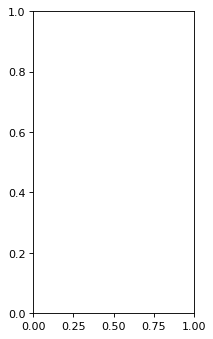

In [6]:
NNarray = ['NNL0','NNL0.01','NNA','MLRL0','NNA0.01']
TITarray = [r'$\mathrm{\left(a\right)\ NNU}$',
           r'$\mathrm{\left(b\right)\ NNL}\left(\alpha=0.01\right)$',
           r'$\left(\mathrm{c}\right)\ \mathrm{NNA}$',
            r'$\mathrm{\left(d\right)\ MLR}$',
           r'$\mathrm{\left(e\right)\ NNA}\left(\alpha=0.01\right)$'];
VAR = 'TPHYSTND'

plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Pressure/lat
for i in range(len(NNarray)):
    print(i)
    plt.subplot(1, len(NNarray), i+1)
    # Load statistics
    md = {}; NN = {};
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'md.pkl','rb'))

    A = md.stats['r2'][:, :, md.get_output_var_idx(VAR)].mean(1).T;
    plt.pcolor(lat,P,A,cmap='Spectral',vmin=0,vmax=1)
    #if i==2: plt.colorbar();
    plt.ylim((0,1000))
    plt.gca().invert_yaxis()
    plt.title(TITarray[i])
    plt.xlabel(r'$\mathrm{latitude}\left[^{\circ}\right]$')
    if i==0: plt.ylabel(r'$\mathrm{Pressure\ \left[hPa\right]}$')
    else: plt.gca().axes.get_yaxis().set_ticks([])
    if i==len(NNarray): plt.colorbar()


0
Loading model
Loading statistics
1
Loading model
Loading statistics
2
Loading model
Loading statistics
3
Loading model
Loading statistics
4
Loading model
Loading statistics


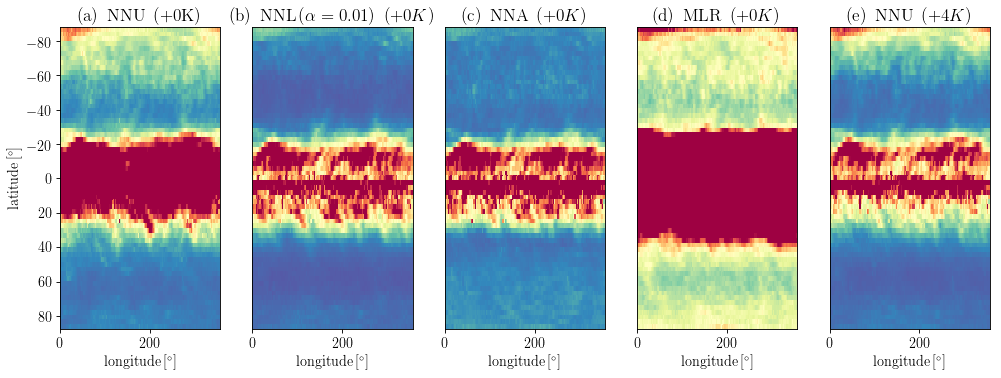

In [17]:
NNarray = ['NNL0','NNL0.01','NNA','MLRL0','NNA0.01']
VAR = 'FLNT'

sst = 4
if sst==0: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
else: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_1'+str(sst)+'_valid.nc'

plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Pressure/lat
for i in range(len(NNarray)):
    print(i)
    plt.subplot(1, len(NNarray), i+1)
    # Load statistics
    md = {}; NN = {};
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    if sst==0: path_end = 'md.pkl'
    else: path_end = 'md'+str(sst)+'K.pkl'
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+path_end,'rb'))

    A = md.stats['r2'][:, :, md.get_output_var_idx(VAR)].T;
    plt.pcolor(lon,lat,A[0,:,:].T,cmap='Spectral',vmin=0,vmax=1)
    #if i==2: plt.colorbar();
    plt.gca().invert_yaxis()
    plt.title(TITarray[i])
    plt.xlabel(r'$\mathrm{longitude}\left[^{\circ}\right]$')
    if i==0: plt.ylabel(r'$\mathrm{latitude}\left[^{\circ}\right]$')
    else: plt.gca().axes.get_yaxis().set_ticks([])
    if i==len(NNarray): plt.colorbar()

In [2]:
!ls $TRAINDIR'HDF5_DATA/'

C_009.h5	       NNA0.01mdprecip3K.pkl  NNL0.99.h5
C_rad2_5dens.h5        NNA0.01mdprecip4K.pkl  NNL0.99md1K.pkl
C_rad_5dens.h5	       NNA0.01mdprecip.pkl    NNL0.99md2K.pkl
HDF5_DATA	       NNA0.01res1K.pkl       NNL0.99md3K.pkl
J01_NNA.h5	       NNA0.01res2K.pkl       NNL0.99md4K.pkl
J01_NNAmd.pkl	       NNA0.01res3K.pkl       NNL0.99md.pkl
J01_NNLA.h5	       NNA0.01res4K.pkl       NNL0.99res1K.pkl
J01_NNLAmd.pkl	       NNA0.01res.pkl	      NNL0.99res2K.pkl
J01_NNL.h5	       NNADS1.h5	      NNL0.99res3K.pkl
J01_NNLmd.pkl	       NNADS1md1K.pkl	      NNL0.99res4K.pkl
J01_NNU.h5	       NNADS1md2K.pkl	      NNL0.99res.pkl
J01_NNUmd.pkl	       NNADS1md3K.pkl	      NNL0DS1_0.h5
JNNC.h5		       NNADS1md4K.pkl	      NNL0DS1_10.h5
JNNCmd4K.pkl	       NNADS1md5K.pkl	      NNL0DS1_11.h5
JNNCmd.pkl	       NNADS1res1K.pkl	      NNL0DS1_12.h5
JNNCmdres4K.pkl        NNADS1res2K.pkl	      NNL0DS1_13.h5
JNNCmdres.pkl	       NNADS1res3K.pkl	      NNL0DS1_14.h5
JNNL0.01.h5	       NNADS1res4K.pkl	      N

tgb - 6/19/2019 - Analyze the output-by-output error between unconstrained and conserving

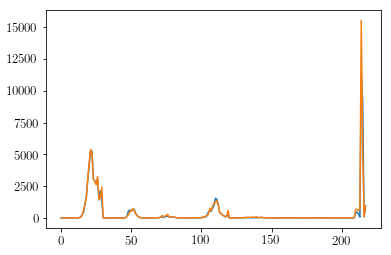

In [25]:
plt.plot(msevec[0,1,:])
plt.plot(msevec[1,1,:])

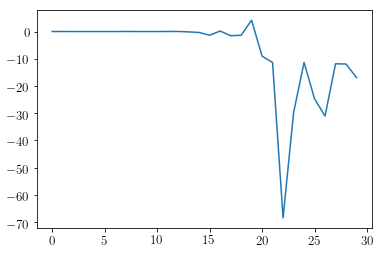

In [73]:
plt.plot(msevec[0,0,:30]-msevec[1,0,:30]) # Error from NNU - Error for NNC for +0K

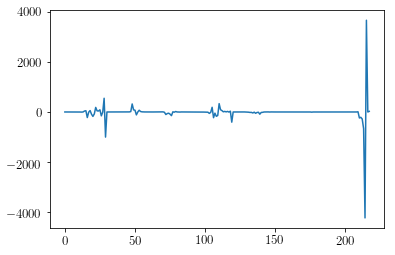

In [27]:
Error = msevec[0,1,:]-msevec[1,1,:]
plt.plot(Error) # Error from NNU - Error for NNC for +4K

In [43]:
np.sum(Error[:30])

-706.3114981464271

In [54]:
Error[214:218]

array([-4.22728482e+03,  3.66009369e+03, -1.22938527e+00,  2.46305653e+01])

In [36]:
Error_sort = np.argsort(Error)
print(Error_sort[210:218])
Error[Error_sort[210:218]]

[ 25 111  22 105  48 110  28 215]


array([  86.59523101,   89.48531305,  182.44784661,  187.00820454,
        319.69161027,  332.53070372,  547.14563054, 3660.09369049])

In [38]:
coor.lev

<xarray.DataArray 'lev' (lev: 30)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  38.2683  ,  54.59548 ,
        72.012451,  87.82123 , 103.317127, 121.547241, 142.994039, 168.22508 ,
       197.908087, 232.828619, 273.910817, 322.241902, 379.100904, 445.992574,
       524.687175, 609.778695, 691.38943 , 763.404481, 820.858369, 859.534767,
       887.020249, 912.644547, 936.198398, 957.48548 , 976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

So in this particular case, the top error is  
215 = PRECTEND  
28 = dqv/dt(976hPa)  
110 = dT/dt(691hPa)  
48 = dql/dt(445hPa)  
105 = dT/dt(...)  
So not that visible in the R2 feature  

In [63]:
np.size(NNarray)

4

In [71]:
np.expand_dims(md.stats['r2'][:, :, md.get_output_var_idx(VAR)[15:30]].mean(axis=2),axis=2).shape

(64, 128, 1)

j= 0 and sst= 0
i = 0  so plotting Subplot # 1
Loading model
Loading statistics
JNNL
MSE 148.5863357842754
PEN 91.35458150483636
PEN_MASS 37.9617690677476
PEN_ENT 50.25331842894248
PEN_LW 1.8184309395425369
PEN_SW 1.3210630686037772
i = 1  so plotting Subplot # 2
Loading model
Loading statistics
JNNL0.01
MSE 150.6955531338909
PEN 38.101869734590316
PEN_MASS 16.188380497732602
PEN_ENT 18.674542229060638
PEN_LW 1.8460876736439396
PEN_SW 1.3928593341531301
i = 2  so plotting Subplot # 3
Loading model
Loading statistics
JNNC
MSE 152.4882037592579
PEN 7.712282381678843e-10
PEN_MASS 2.1350383444616126e-10
PEN_ENT 4.771463233548023e-10
PEN_LW 4.577332721457281e-11
PEN_SW 3.480475315234766e-11
i = 3  so plotting Subplot # 4
Loading model
Loading statistics
MLRL0
MSE 295.2749784945916
PEN 27.711202449159284
PEN_MASS 16.05936744894416
PEN_ENT 8.27065643040506
PEN_LW 1.3476917967197466
PEN_SW 2.0334867730903317
j= 1 and sst= 4
i = 0  so plotting Subplot # 5
Loading model
Loading statistics
JNNL
M

Text(0, 0.5, '$\\mathrm{R^{2}\\ score}$')

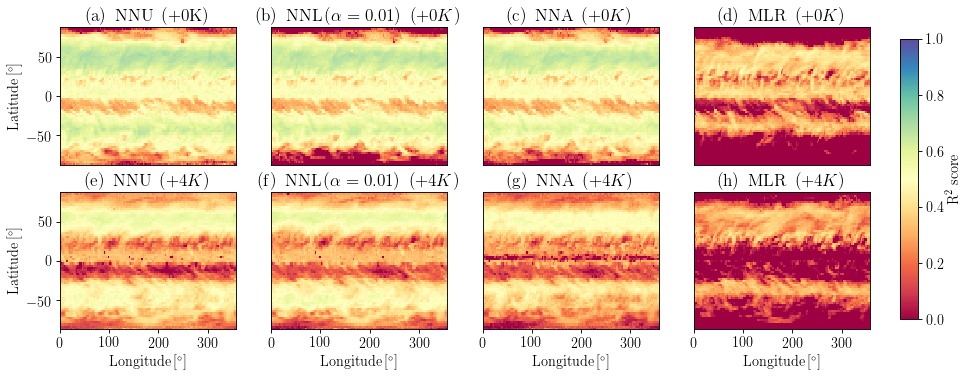

In [72]:
fz = 13
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
#NNarray = ['JNNL','JNNC']
TITarray = [r'$\mathrm{\left(a\right)\ NNU\ \left(+0K\right)}$',
           r'$\mathrm{\left(b\right)\ NNL}\left(\alpha=0.01\right)\ \left(+0K\right)$',
           r'$\mathrm{\left(c\right)\ NNA}\ \left(+0K\right)$',
            r'$\mathrm{\left(d\right)\ MLR}\ \left(+0K\right)$',
           r'$\mathrm{\left(e\right)\ NNU}\ \left(+4K\right)$',
           r'$\mathrm{\left(f\right)\ NNL}\left(\alpha=0.01\right)\ \left(+4K\right)$',
           r'$\mathrm{\left(g\right)\ NNA}\ \left(+4K\right)$',
            r'$\mathrm{\left(h\right)\ MLR}\ \left(+4K\right)$'];
VAR = 'PHQ'

SST = [0,4]
msevec = np.zeros((np.size(NNarray),np.size(SST),218))


plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
fig, axes = plt.subplots(nrows=len(SST), ncols=len(NNarray),\
                        num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Pressure/lat
for j,sst in enumerate(SST):
    print('j=',j,'and sst=',sst)
    if sst==0: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
    else: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_1'+str(sst)+'_valid.nc'
    for i in range(len(NNarray)):
        #plt.subplot(2, len(NNarray), i+1+j*len(NNarray))
        print('i =',i,' so plotting Subplot #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
        print('Loading statistics') # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)
        
        # 3) Calculate statistics and save in pickle file
        if sst==0: path_end = 'md.pkl'; pathres = 'mdres.pkl'
        else: path_end = 'md'+str(sst)+'K.pkl'; pathres = 'mdres'+str(sst)+'K.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+path_end,'rb'))
        md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+pathres,'rb'))

        print(NNarray[i])
        print('MSE',md.mse_W2m4().mean((0,1,2)))
        msevec[i,j,:] = md.mse_W2m4().mean((0,1)) # Save the MSE for each output
        print('PEN',0.25*(md.res['mass']+md.res['ent']+\
                          md.res['sw']+md.res['lw']).mean((0,1,2)))
        print('PEN_MASS',0.25*(md.res['mass']).mean((0,1,2)))
        print('PEN_ENT',0.25*(md.res['ent']).mean((0,1,2)))
        print('PEN_LW',0.25*(md.res['lw']).mean((0,1,2)))
        print('PEN_SW',0.25*(md.res['sw']).mean((0,1,2)))
        
        A = np.expand_dims(md.stats['r2'][:, :, md.get_output_var_idx(VAR)[15:30]].mean(axis=2),axis=2).T;
        AX = axes.flat[i+j*len(NNarray)]
        im = AX.pcolor(lon,lat,A[0,:,:].T,cmap='Spectral',vmin=0,vmax=1)
        AX.set_title(TITarray[i+j*len(NNarray)])
        if j+1==len(SST): AX.set_xlabel(r'$\mathrm{Longitude}\left[^{\circ}\right]$')
        else: AX.get_xaxis().set_ticks([])
        if i==0: AX.set_ylabel(r'$\mathrm{Latitude}\left[^{\circ}\right]$')
        else: AX.get_yaxis().set_ticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, pad = 0.1)
cbar.ax.set_ylabel(r'$\mathrm{R^{2}\ score}$', rotation=90)

j= 0 and sst= 0
i = 0  so plotting Subplot # 1
Loading model
Loading statistics
222.72637090713914
j= 1 and sst= 4
i = 0  so plotting Subplot # 2
Loading model
Loading statistics
229.44872989580745


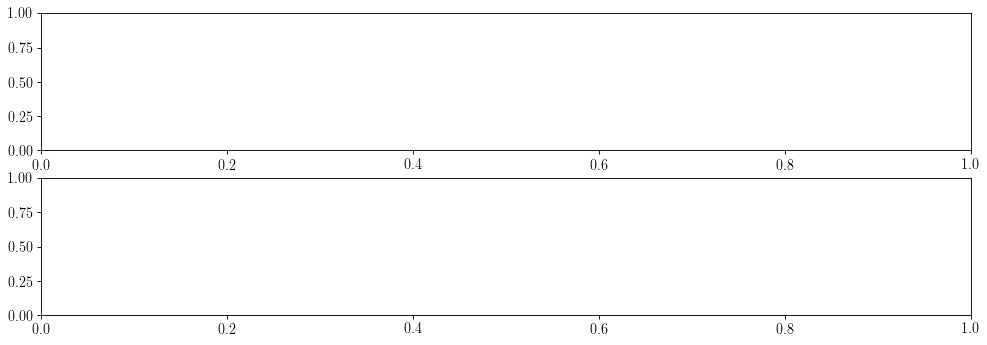

In [14]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
fz = 13

#NNarray = ['NNL0','NNL0.01','NNA','MLRL0']
NNarray = ['NNL0']
TITarray = [r'$\mathrm{\left(a\right)\ NNU\ \left(+0K\right)}$',
           r'$\mathrm{\left(b\right)\ NNL}\left(\alpha=0.01\right)\ \left(+0K\right)$',
           r'$\mathrm{\left(c\right)\ NNA}\ \left(+0K\right)$',
            r'$\mathrm{\left(d\right)\ MLR}\ \left(+0K\right)$',
           r'$\mathrm{\left(e\right)\ NNU}\ \left(+4K\right)$',
           r'$\mathrm{\left(f\right)\ NNL}\left(\alpha=0.01\right)\ \left(+4K\right)$',
           r'$\mathrm{\left(g\right)\ NNA}\ \left(+4K\right)$',
            r'$\mathrm{\left(h\right)\ MLR}\ \left(+4K\right)$'];
VAR = 'FLNT'

SST = [0,4]

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
fig, axes = plt.subplots(nrows=len(SST), ncols=len(NNarray),\
                        num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Pressure/lat
for j,sst in enumerate(SST):
    print('j=',j,'and sst=',sst)
    if sst==0: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
    else: data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_1'+str(sst)+'_valid.nc'
    for i in range(len(NNarray)):
        #plt.subplot(2, len(NNarray), i+1+j*len(NNarray))
        print('i =',i,' so plotting Subplot #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
        print('Loading statistics') # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        if sst==0: path_end = 'md.pkl'
        else: path_end = 'md'+str(sst)+'K.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+path_end,'rb'))
        
        print(md.stats['true_mean'][:, :, md.get_output_var_idx(VAR)].T.mean())

In [17]:
del_OLR = 229.44872989580745-222.72637090713914
print(del_OLR)

6.722358988668304


In [13]:
print(md.stats['true_mean'][:, :, md.get_output_var_idx(VAR)].T.mean())

222.72637090713914


### 3.1.4) Figure 3d: R2 maps of longwave heating for NN0,NN0.5,NNA,MLR0

0
Loading model
Loading statistics
1
Loading model
Loading statistics
2
Loading model
Loading statistics
3
Loading model
Loading statistics


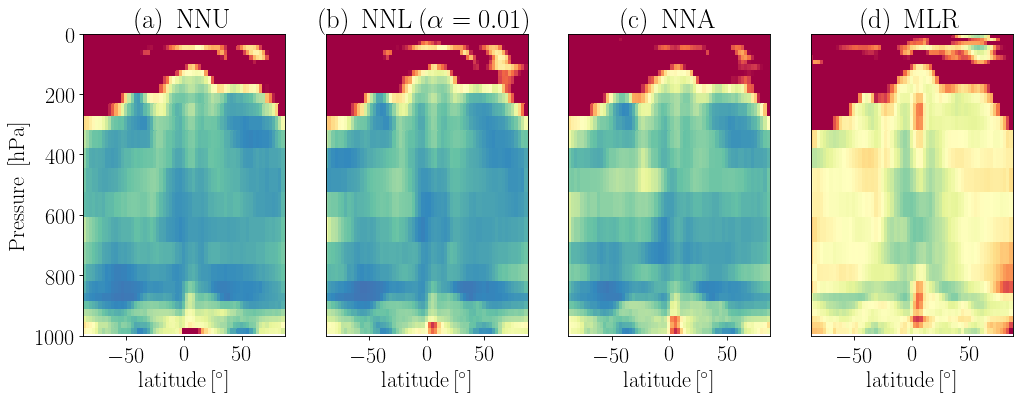

In [86]:
NNarray = ['NNL0','NNL0.01','NNA','MLRL0']

plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

for i in range(len(NNarray)):
    print(i)
    plt.subplot(1, len(NNarray), i+1)
    # Load statistics
    md = {}; NN = {};
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'md.pkl','rb'))

    A = md.stats['r2'][:, :, md.get_output_var_idx('QRL')].mean(1).T;
    plt.pcolor(lat,P,A,cmap='Spectral',vmin=0,vmax=1)
    #if i==2: plt.colorbar();
    plt.ylim((0,1000))
    plt.gca().invert_yaxis()
    plt.title(TITarray[i])
    plt.xlabel(r'$\mathrm{latitude}\left[^{\circ}\right]$')
    if i==0: plt.ylabel(r'$\mathrm{Pressure\ \left[hPa\right]}$')
    else: plt.gca().axes.get_yaxis().set_ticks([])
    if i==len(NNarray): plt.colorbar()

## 3.2) Figure 4: Generalization abilities to climate change  
### 3.2.1) Figure 4a: MSE/Constraint Penalty as a function of surface temperature

In [8]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

NNarray = ['NNL0','NNL0.5','NNA','NNL0.01']
#NNarray = ['NNL0','NNL0.01','NNA','MLRL0']
# First calculate MSE/Penalty as function of temperature for NNU,NN0.5,NNA,MLR
MSEt={}; PENt={};
data_fn_array = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
                 '/local/Tom.Beucler/SPCAM_PHYS/8col009_11_valid.nc',
                 '/local/Tom.Beucler/SPCAM_PHYS/8col009_12_valid.nc',
                 '/local/Tom.Beucler/SPCAM_PHYS/8col009_13_valid.nc',
                 '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc']

for n,NNs in enumerate(NNarray):
    NN = {};
    print('Network is ',NNs)
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.h5',custom_objects=dict_lay)
    for T,data_fn in enumerate(data_fn_array):
        md =  {};
        print('Loading statistics in ',data_fn) # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        if T==0: 
            md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+
                                    'md.pkl','rb'))
            md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+
                                    'res.pkl','rb'))
        else:
            md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+
                                        'md'+str(T)+'K.pkl','rb'))
            md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+
                                      'res'+str(T)+'K.pkl','rb'))
        MSEt[NNs,T] = md.mse_W2m4().mean((0,1,2))
        PENt[NNs,T] = 0.25*(md.res['mass']+md.res['ent']+\
                           md.res['sw']+md.res['lw']).mean((0,1,2))
        

Network is  NNL0
Loading model
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_11_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_12_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_13_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc
Network is  NNL0.5
Loading model
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_11_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_12_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_13_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc
Network is  NNA
Loading model
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc
Loading statistics in  /local/Tom.Beucler/SPCAM_PHYS/8col009_11_valid.nc
Loading statistics in  /local/

In [66]:
MSEt[('NNL0.5',3)]

344.80505958078726

Network is  NNL0
Network is  NNL0.5
Network is  NNA
Network is  NNL0.01


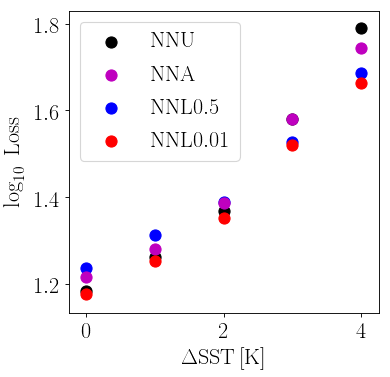

In [74]:
Tarray = [0,1,2,3,4]
Marray = ['o','o','o','o']

COLOR = ['k','b','m','r']

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')

for n,NNs in enumerate(NNarray):
    print('Network is ',NNs)
    for T in range (5):
        MSEs[NNs] = plt.scatter(T,np.log10(MSEt[(NNs,T)]/SN**2),c=COLOR[n],s=siz,marker=Marray[n])
        #PENs[NNs] = plt.scatter(T,np.log10(PENt[(NNs,T)]/SN**2),c='b',s=siz,marker=Marray[n])
    
# MSEs['NNA'] = plt.scatter(XNNA,np.log10(MSEa['NNA']/SN**2),c='k',s=siz)
# PENs['NNA'] = plt.scatter(XNNA,YMIN+0.1,c='b',s=3*siz,marker="$\downarrow$")
# MSEt = plt.text(XNNA-XTEXT,np.log10(MSEa['NNA']/SN**2)-YTEXT,s='$\mathrm{NNA}$',color='k')
# PENt = plt.text(XNNA-XTEXT,YMIN+0.1+YTEXT/2,s='$\mathrm{NNA}$',color='b')
    
plt.xlim((-0.25,4.25))
#plt.ylim((1.15,1.85))
plt.xlabel(r'$\Delta\mathrm{SST}\left[\mathrm{K}\right]$')
plt.ylabel(r'$\log_{10}\ \mathrm{Loss}$'),
plt.legend((MSEs['NNL0'],MSEs['NNA'],MSEs['NNL0.5'],MSEs['NNL0.01']),\
           ('$\mathrm{NNU}$','$\mathrm{NNA}$','$\mathrm{NNL0.5}$','$\mathrm{NNL0.01}$'))

Loading model
Loading statistics
Loading model
Loading statistics


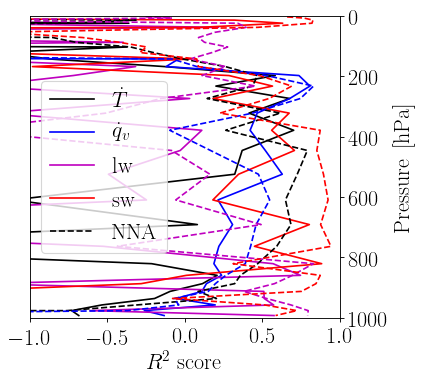

In [84]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

vec = [3,0,4,5]
COLOR = ['k','b','m','r']
LABEL = ['$\dot{T}$','$\dot{q}_{v}$','$\mathrm{lw}$','$\mathrm{sw}$','$\mathrm{NNA}$','','','','','','','']
LIN = ['-','--',':']
LINE = {}
NNarray = ['NNL0','NNA']

plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')

for j in range(len(NNarray)):
    # Load statistics
    md = {}; NN = {};
    # Load statistics
    md = {}; NN = {};
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[j]+'.h5',custom_objects=dict_lay)
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[j]+'md4K.pkl','rb'))

    # Plot vertical profile of R2(p)
    for i,v in enumerate([md.valid_gen.output_vars[x] for x in vec]):
        LINE[i,j] = plt.plot(md.stats['hor_r2'][md.get_output_var_idx(v)],\
                 P, color=COLOR[i], linestyle=LIN[j], label=LABEL[i+4*j])

plt.xlim((-1, 1))
plt.ylim((0,1000))
plt.xlabel(r'$R^{2}\ \mathrm{score}$')
plt.ylabel(r'$\mathrm{Pressure\ \left[hPa\right]}$')
plt.gca().invert_yaxis()
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.legend()

0
Loading model
Loading statistics
1
Loading model
Loading statistics
2
Loading model
Loading statistics
3
Loading model
Loading statistics


FileNotFoundError: [Errno 2] No such file or directory: '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/MLRL0md4K.pkl'

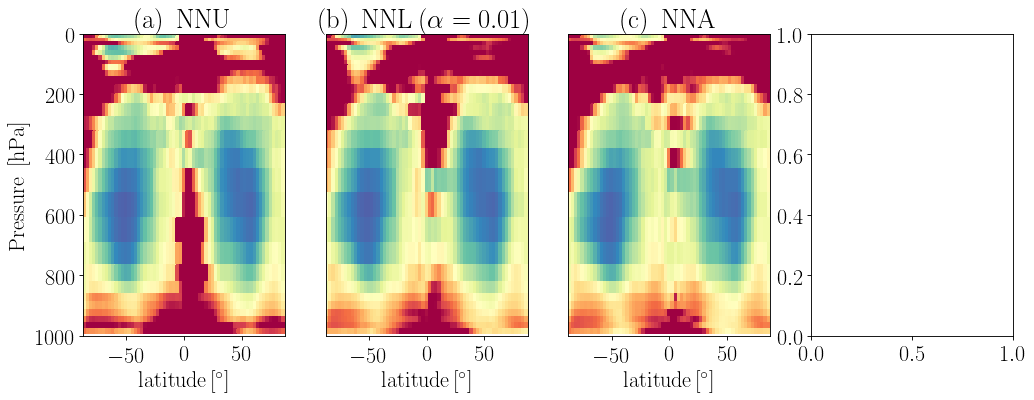

In [80]:
NNarray = ['NNL0','NNL0.01','NNA','MLRL0']
TITarray = [r'$\mathrm{\left(a\right)\ NNU}$',
           r'$\mathrm{\left(b\right)\ NNL}\left(\alpha=0.01\right)$',
           r'$\left(\mathrm{c}\right)\ \mathrm{NNA}$',
            r'$\mathrm{\left(d\right)\ MLR}$']; 

plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

for i in range(len(NNarray)):
    print(i)
    plt.subplot(1, len(NNarray), i+1)
    # Load statistics
    md = {}; NN = {};
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'md4K.pkl','rb'))

    A = md.stats['r2'][:, :, md.get_output_var_idx('TPHYSTND')].mean(1).T;
    plt.pcolor(lat,P,A,cmap='Spectral',vmin=0,vmax=1)
    #if i==2: plt.colorbar();
    plt.ylim((0,1000))
    plt.gca().invert_yaxis()
    plt.title(TITarray[i])
    plt.xlabel(r'$\mathrm{latitude}\left[^{\circ}\right]$')
    if i==0: plt.ylabel(r'$\mathrm{Pressure\ \left[hPa\right]}$')
    else: plt.gca().axes.get_yaxis().set_ticks([])
    if i==len(NNarray): plt.colorbar()


0
Loading model
Loading statistics
1
Loading model
Loading statistics
2
Loading model
Loading statistics
3
Loading model
Loading statistics


FileNotFoundError: [Errno 2] No such file or directory: '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/MLRL0md4K.pkl'

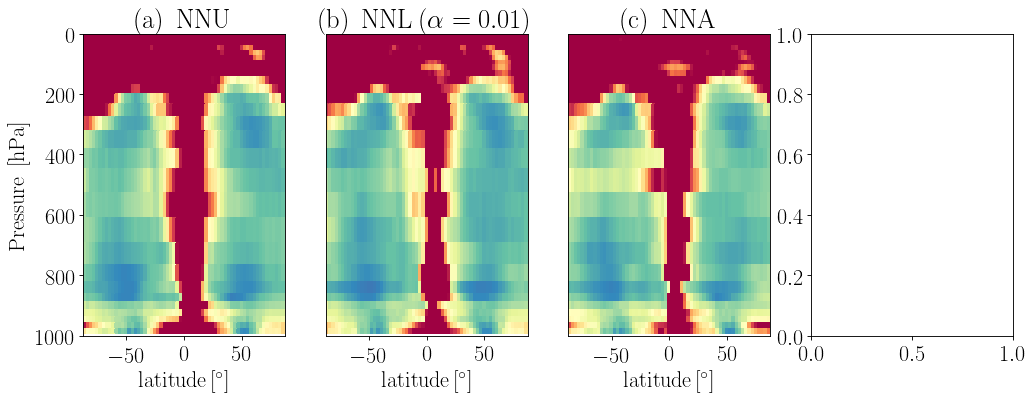

In [87]:
NNarray = ['NNL0','NNL0.01','NNA','MLRL0']
TITarray = [r'$\mathrm{\left(a\right)\ NNU}$',
           r'$\mathrm{\left(b\right)\ NNL}\left(\alpha=0.01\right)$',
           r'$\left(\mathrm{c}\right)\ \mathrm{NNA}$',
            r'$\mathrm{\left(d\right)\ MLR}$']; 

plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

for i in range(len(NNarray)):
    print(i)
    plt.subplot(1, len(NNarray), i+1)
    # Load statistics
    md = {}; NN = {};
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
    print('Loading statistics') # 2) Define model diagnostics object
    md = ModelDiagnostics(NN,config_fn,data_fn)
    # 3) Calculate statistics and save in pickle file
    md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'md4K.pkl','rb'))

    A = md.stats['r2'][:, :, md.get_output_var_idx('QRL')].mean(1).T;
    plt.pcolor(lat,P,A,cmap='Spectral',vmin=0,vmax=1)
    #if i==2: plt.colorbar();
    plt.ylim((0,1000))
    plt.gca().invert_yaxis()
    plt.title(TITarray[i])
    plt.xlabel(r'$\mathrm{latitude}\left[^{\circ}\right]$')
    if i==0: plt.ylabel(r'$\mathrm{Pressure\ \left[hPa\right]}$')
    else: plt.gca().axes.get_yaxis().set_ticks([])
    if i==len(NNarray): plt.colorbar()


tgb - 4/25/2019 - Quick test for data-scarce network

In [11]:
NN = {}; md = {};
# Repeat for architecture-constrained network
# Path of model/statistics
path_model = TRAINDIR+'HDF5_DATA/NNL0DS1_19.h5'
path_md = TRAINDIR+'HDF5_DATA/NNL0DS1_19md1K.pkl'
path_res = TRAINDIR+'HDF5_DATA/NNL0DS1_19res1K.pkl'
# 1) Load model
NN = load_model(path_model,custom_objects=dict_lay)
# 2) Define and load md
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(path_md,'rb'))
# 3) Load res
md.res = pickle.load(open(path_res,'rb'))
# 4) Fill the MSE and energy/enthalpy arrays
MSEa['NNL0DS1'] = md.mse_W2m4().mean((0,1,2))
PENa['NNL0DS1'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).mean((0,1,2))

In [13]:
NN = {}; md = {};
# Repeat for architecture-constrained network
# Path of model/statistics
path_model = TRAINDIR+'HDF5_DATA/NNADS1.h5'
path_md = TRAINDIR+'HDF5_DATA/NNADS1md1K.pkl'
path_res = TRAINDIR+'HDF5_DATA/NNADS1res1K.pkl'
# 1) Load model
NN = load_model(path_model,custom_objects=dict_lay)
# 2) Define and load md
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(path_md,'rb'))
# 3) Load res
md.res = pickle.load(open(path_res,'rb'))
# 4) Fill the MSE and energy/enthalpy arrays
MSEa['NNADS1'] = md.mse_W2m4().mean((0,1,2))
PENa['NNADS1'] = 0.25*(md.res['mass']+md.res['ent']+\
                    md.res['sw']+md.res['lw']).mean((0,1,2))

In [14]:
MSEa

{'0': 156.4755077339127,
 '0.01': 154.00014306528615,
 '0.25': 163.8660779267188,
 '0.5': 177.20805425056002,
 '0.75': 212.16629553845567,
 '0.99': 388.51354581649787,
 '1': 2125.4165518263144,
 'NNA': 168.94318558526123,
 'MLRL0': 295.27497987468007,
 'MLRA': 296.3175040441273,
 'NNL0DS1': 260.66990532878395,
 'NNADS1': 301.2835246335441}